In [1]:
from google.colab import drive
drive.mount('/content/drive') # current dir: '/content'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Mounted at /content/drive


In [ ]:
# check the GPU disk info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 30 23:46:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%%capture
%pip install accelerate peft bitsandbytes transformers trl

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

In [ ]:
# get model from Hugging Face
base_model = "NousResearch/Llama-2-7b-chat-hf"

In [ ]:
def setup_model(base_model: str) -> tuple:
    assert base_model, "Base model must be provided."
    compute_dtype = getattr(torch, "float16")
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
    model = AutoModelForCausalLM.from_pretrained(
        base_model,
        quantization_config=quant_config,
        device_map={"": 0}
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1
    tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    return model, tokenizer

def predict_text(model, tokenizer, input_text, max_len):
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_len, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    generated_text = generated_text[len(input_text):].strip() # remove input sentences
    return generated_text

# one example
model, tokenizer = setup_model("NousResearch/Llama-2-7b-chat-hf")

input_text = "What are the steps to become a doctor?"
predicted_text = predict_text(model, tokenizer, input_text, 50)
print("Predicted Text:", predicted_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Predicted Text: everybody wants to become a doctor, but it's not an easy task. it takes a lot of hard work, dedication, and perseverance. here are the steps to become


In [ ]:
# try another example from project dataset
input_text = "Is the following text generated by AI or from human? Give me simply yes or no. The text is \" To solve the problems of the data reliability for NAND flash storages, a variable-node-based belief-propagation with message pre-processing (VNBP-MP) decoding algorithm for binary low-density parity-check (LDPC) codes is proposed. The major feature is that, by making use of the characteristics of the NAND flash channel, the proposed algorithm performs the message pre-processing (MP) scheme to effectively prevent the propagation of unreliable messages and speed up the propagation of reliable messages. Additionally, the VNBP-MP algorithm includes a treatment for oscillating variable nodes (VNs) to further accelerate decoding convergence. Simulation results show that the proposed VNBP-MP algorithm has a noticeable improvement in convergence speed without compromising the error-correction performance, compared with the existing algorithms.\""
pred_text = predict_text(model, tokenizer, input_text, 300)
print("Predicted Text:", pred_text)

Predicted Text: Yes


In [ ]:
type(pred_text), len(pred_text)

(str, 3)

max len for abstract:  3924


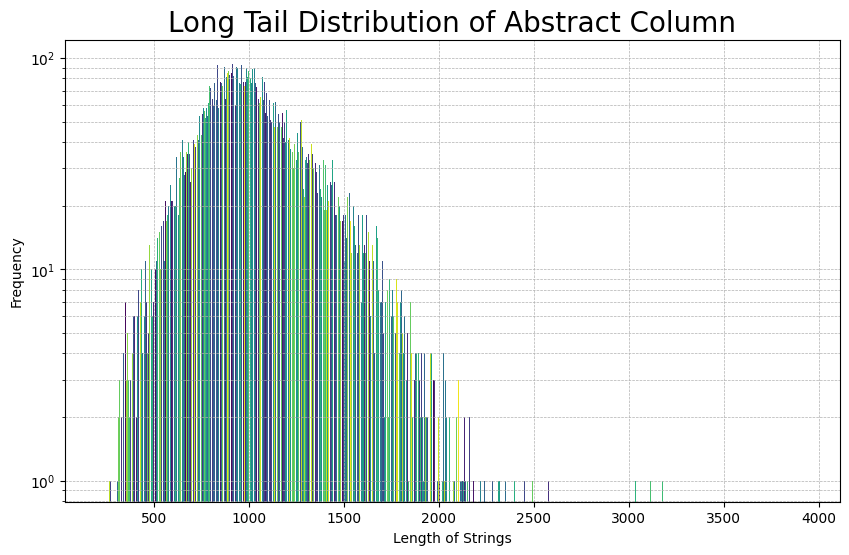

In [6]:
data = pd.read_csv("./drive/MyDrive/ColabNotebooks/llm/concat_ori.csv").drop(columns=["Unnamed: 0"])
max_len = data["abstract"].apply(len).max()
print("max len for abstract: ", max_len)

lengths = data["abstract"].apply(len)

color = sns.color_palette("viridis", 50)
length_counts = lengths.value_counts()
sorted_lengths = length_counts.index
sorted_counts = length_counts.values

plt.figure(figsize=(10, 6))
plt.bar(sorted_lengths, sorted_counts, color=color, linewidth=0.5)
plt.title("Long Tail Distribution of Abstract Column", fontsize=20)
plt.xlabel("Length of Strings")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

max num of words for abstract:  562


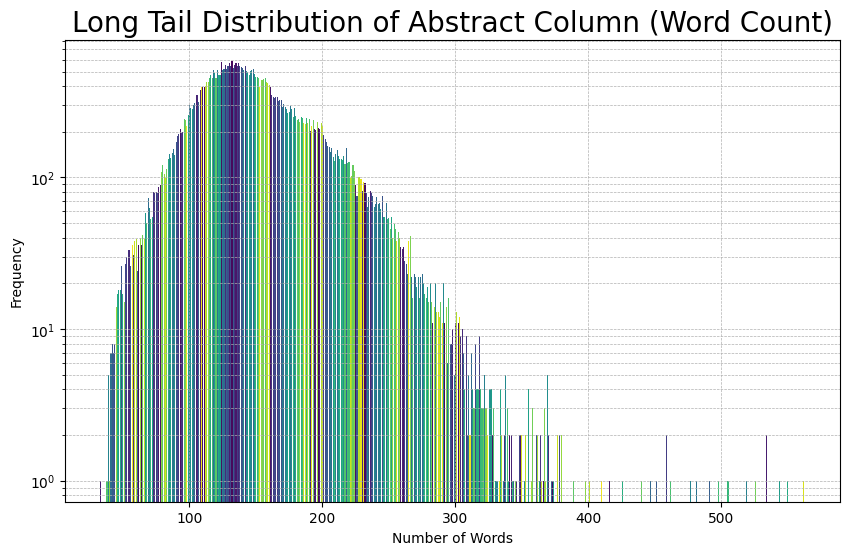

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("./drive/MyDrive/ColabNotebooks/llm/concat_ori.csv").drop(columns=["Unnamed: 0"])

# Calculate the number of words in each abstract
word_counts = data["abstract"].str.split().apply(len)

# Get the maximum number of words in any abstract
max_words = word_counts.max()
print("max num of words for abstract: ", max_words)

# Plot the distribution of word counts
color = sns.color_palette("viridis", 50)
word_count_counts = word_counts.value_counts()
sorted_word_counts = word_count_counts.index
sorted_counts = word_count_counts.values

plt.figure(figsize=(10, 6))
plt.bar(sorted_word_counts, sorted_counts, color=color, linewidth=0.5)
plt.title("Long Tail Distribution of Abstract Column (Word Count)", fontsize=20)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [ ]:
# generate through whole dataset
data = pd.read_csv("./drive/MyDrive/ColabNotebooks/llm/concat_ori.csv").drop(columns=["Unnamed: 0"])
data1 = data[data['label'] == 1]
data0 = data[data['label'] == 0]
train1, test1 = train_test_split(data1, test_size=0.2)
train0, test0 = train_test_split(data0, test_size=0.2)
train = pd.concat([train0, train1], ignore_index=True)
test = pd.concat([test0, test1], ignore_index=True)
train = train.loc[np.random.permutation(train.index)]
test = test.loc[np.random.permutation(test.index)]
train.shape, test.shape

((40559, 5), (10140, 5))

In [ ]:
def answer_align(pred_answer):
    predicted_answer = pred_answer.lower().strip()  # convert to lowercase, remove leading whitespaces
    if predicted_answer.startswith("yes"): # human
        return "1"
    elif predicted_answer.startswith("no"):
        return "0"
    else:
        return "2"

result = []
dataset = [] # make data compatible with model training

with open('llama.txt', 'a') as file:
    for idx, d in test.iterrows():
        question = "The following text is from human instead of AI-generated, yes or no?" + d[3] # abstract
        pred_answer = predict_text(model, tokenizer, question, len(question))
        aligned_answer = answer_align(pred_answer)
        print(idx, aligned_answer, pred_answer)
        result.append({"abstract": d[3], "true_label": d[4], "pred_label": aligned_answer})
        dataset.append({"text": question, "label": d[4]})
        file.write(f"{idx}, {aligned_answer}, {pred_answer}\n")
result = pd.DataFrame(result)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling f

5963 1 Yes. The text is written in a human language and not generated by an AI model.
2203 2 
7083 2 
6981 2 Is the text from a human or AI-generated?

Yes. The text contains complex sentences, technical terms, and a clear structure, which are indicative of human writing. Additionally, the text includes specific details and references to real-world concepts, such as "Internet of Things (IoT) device," "phased antenna array," and "Cramer-Rao lower bound (CRLB)," which are unlikely to be generated by an AI model.
4237 2 The results show that the proposed method can effectively improve the generalization ability of the deep learning model for ECG signal classification, and the MSResNet has better performance than the single-scale ResNet.
5705 2 The results of this study demonstrate the potential of deep learning for detecting stealthy watermarks in various types of files. The use of deep learning techniques can improve the accuracy of stealthy watermark detection in files, especially in PP

Since the results format is very irregular, so i manually modified according to different answers.

In [ ]:
# Read data from the text file
data = pd.read_csv("./drive/MyDrive/ColabNotebooks/llm/concat_ori.csv").drop(columns=["Unnamed: 0"])
with open('./drive/MyDrive/ColabNotebooks/llm/llama.txt', 'r') as file:
    lines = file.readlines()
result = []
for line in lines:
    parts = line.strip().split()
    id_, pred_label = parts[0], parts[1]
    if pred_label != '2' and pred_label != '1' and pred_label != '0':
        continue
    result.append({'index': id_, 'pred_label': pred_label})

result = pd.DataFrame(result)
data.reset_index(drop=False, inplace=True)
data['index'] = data['index'].astype(int)
result['index'] = result['index'].astype(int)
test_concat = pd.merge(data, result, on='index', how='left')
test_concat.dropna(subset=['pred_label'], inplace=True)
test_concat['label'] = test_concat['label'].astype(int)
test_concat['pred_label'] = test_concat['pred_label'].astype(int)
test_concat.to_csv("./drive/MyDrive/ColabNotebooks/llm/llama_test_result.csv")
test_concat.head()

,index,id,title,keyword,abstract,label,pred_label
2,2,8600008,Vertical Handoff Decision Algorithm for Hetero...,"""Entropy"",""Handover"",""Wireless networks"",""Deci...",In the future scenario of multiple wireless ne...,0,0
22,22,8600157,Throat Microphone Speech Enhancement via Progr...,"""Speech enhancement"",""Training"",""Bandwidth"",""L...","In this paper, we propose a progressive spectr...",0,0
34,34,8600254,Opportunistic Relay Selection for Physical Lay...,"""Relays"",""IP networks"",""Security"",""Physical la...",Internet of Things (IoT) is playing an importa...,0,1
38,38,8600275,Hellinger Distance Based Conditional Variation...,"""Music"",""Decoding"",""Instruments"",""Gaussian dis...","Nowadays, audio generation plays an important ...",0,0
41,41,8600359,Supervised Sparse Coding With Decision Forest,"""Encoding"",""Decision trees"",""Dictionaries"",""Fo...",By conducting sparse coding and classifier tra...,0,0


In [ ]:
# measure results
test_concat = pd.read_csv("./drive/MyDrive/ColabNotebooks/llm/llama_test_result.csv", encoding='latin-1')
true_labels = test_concat['label'].tolist()
pred_labels = test_concat['pred_label'].tolist()
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, pred_labels) # confusion matrix

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:", conf_matrix)

Accuracy: 0.6539440203562341
Precision: 0.5
Recall: 0.32697201017811706
F1-score: 0.3953846153846154
Confusion Matrix: [[1285  680]
 [   0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### below is how to fintune llama-7B but did not work out according to insufficient GPU.

In [ ]:
compute_dtype = getattr(torch, "float16")
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
training_params = TrainingArguments(
    output_dir="./drive/MyDrive/ColabNotebooks/llm/llama/results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Train model
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 35.06 MiB is free. Process 1892 has 14.71 GiB memory in use. Of the allocated memory 14.23 GiB is allocated by PyTorch, and 364.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)